In [311]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score
from tqdm import tqdm  
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


In [312]:
#loading the data

all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

                
#Shuffle the data because the raw data is ordered based on the label
random_state = 42
all_data = shuffle(all_data,random_state=random_state)

In [313]:
#parse the data
labels = []
nodes = []
features = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    features.append(elements[1:-1])
    nodes.append(elements[0])

features = np.array(features,dtype=int)
a = features.shape[0] #the number of nodes
b = features.shape[1] #the size of node features

print('features shape: ', features.shape)


features shape:  (2708, 1433)


In [314]:
print(features.shape)

(2708, 1433)


In [315]:
#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (a): ', a)
print('\nNumber of features (b) of each node: ', b)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)


Number of nodes (a):  2708

Number of features (b) of each node:  1433

Categories:  {'Probabilistic_Methods', 'Case_Based', 'Rule_Learning', 'Neural_Networks', 'Theory', 'Genetic_Algorithms', 'Reinforcement_Learning'}

Number of classes:  7


In [316]:
#build the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

print(G)

Graph with 2708 nodes and 5278 edges


In [317]:
#obtain the adjacency matrix (A)
adj = nx.adjacency_matrix(G)

print(adj)


  (0, 469)	1
  (0, 683)	1
  (0, 1571)	1
  (0, 2160)	1
  (0, 2238)	1
  (1, 324)	1
  (1, 762)	1
  (1, 1395)	1
  (1, 2071)	1
  (2, 322)	1
  (2, 459)	1
  (2, 2635)	1
  (3, 606)	1
  (3, 759)	1
  (3, 1410)	1
  (3, 1912)	1
  (3, 1965)	1
  (4, 281)	1
  (4, 1461)	1
  (4, 2527)	1
  (5, 320)	1
  (5, 340)	1
  (5, 353)	1
  (5, 415)	1
  (5, 692)	1
  :	:
  (2700, 756)	1
  (2700, 2610)	1
  (2700, 2647)	1
  (2701, 497)	1
  (2701, 999)	1
  (2701, 1154)	1
  (2701, 1345)	1
  (2701, 1634)	1
  (2701, 2415)	1
  (2702, 170)	1
  (2702, 2302)	1
  (2703, 1518)	1
  (2704, 168)	1
  (2704, 370)	1
  (2704, 686)	1
  (2704, 1082)	1
  (2704, 1839)	1
  (2705, 459)	1
  (2705, 624)	1
  (2705, 2422)	1
  (2706, 1133)	1
  (2707, 989)	1
  (2707, 1320)	1
  (2707, 1710)	1
  (2707, 2687)	1


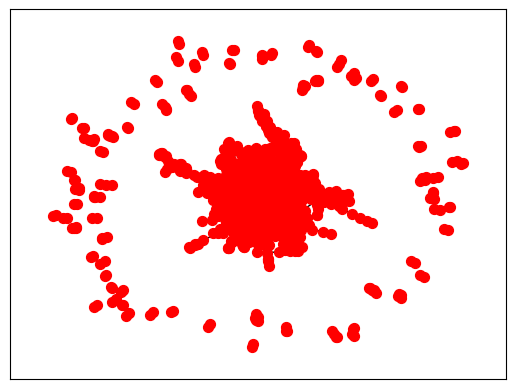

In [318]:
nx.draw_networkx(G, with_labels=False, node_size=50, node_color='r')
plt.show()

In [319]:
# Get normalized adjacency matrix: A_norm
def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)


In [320]:
# Convert sparse matrix to tuple
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

In [321]:
def mask_test_edges(adj, test_frac=.1, val_frac=.05, prevent_disconnect=True, verbose=False):
    # NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.

    if verbose == True:
        print('preprocessing...')

    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    g = nx.from_scipy_sparse_array(adj)

    orig_num_cc = nx.number_connected_components(g)

    adj_triu = sp.triu(adj) # upper triangular portion of adj matrix
    adj_tuple = sparse_to_tuple(adj_triu) # (coords, values, shape), edges only 1 way
    edges = adj_tuple[0] # all edges, listed only once (not 2 ways)
    # edges_all = sparse_to_tuple(adj)[0] # ALL edges (includes both ways)
    num_test = int(np.floor(edges.shape[0] * test_frac)) # controls how large the test set should be
    num_val = int(np.floor(edges.shape[0] * val_frac)) # controls how alrge the validation set should be

    # Store edges in list of ordered tuples (node1, node2) where node1 < node2
    edge_tuples = [(min(edge[0], edge[1]), max(edge[0], edge[1])) for edge in edges]
    all_edge_tuples = set(edge_tuples)
    train_edges = set(edge_tuples) # initialize train_edges to have all edges
    test_edges = set()
    val_edges = set()

    if verbose == True:
        print('generating test/val sets...')

    # Iterate over shuffled edges, add to train/val sets
    np.random.shuffle(edge_tuples)
    for edge in edge_tuples:
        # print edge
        node1 = edge[0]
        node2 = edge[1]

        # If removing edge would disconnect a connected component, backtrack and move on
        g.remove_edge(node1, node2)
        if prevent_disconnect == True:
            if nx.number_connected_components(g) > orig_num_cc:
                g.add_edge(node1, node2)
                continue

        # Fill test_edges first
        if len(test_edges) < num_test:
            test_edges.add(edge)
            train_edges.remove(edge)

        # Then, fill val_edges
        elif len(val_edges) < num_val:
            val_edges.add(edge)
            train_edges.remove(edge)

        # Both edge lists full --> break loop
        elif len(test_edges) == num_test and len(val_edges) == num_val:
            break

    if (len(val_edges) < num_val or len(test_edges) < num_test):
        print("WARNING: not enough removable edges to perform full train-test split!")
        print("Num. (test, val) edges requested: (", num_test, ", ", num_val, ")")
        print("Num. (test, val) edges returned: (", len(test_edges), ", ", len(val_edges), ")")

    if prevent_disconnect == True:
        assert nx.number_connected_components(g) == orig_num_cc

    if verbose == True:
        print('creating false test edges...')

    test_edges_false = set()
    while len(test_edges_false) < num_test:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge not an actual edge, and not a repeat
        if false_edge in all_edge_tuples:
            continue
        if false_edge in test_edges_false:
            continue

        test_edges_false.add(false_edge)

    if verbose == True:
        print('creating false val edges...')

    val_edges_false = set()
    while len(val_edges_false) < num_val:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false:
            continue
            
        val_edges_false.add(false_edge)

    if verbose == True:
        print("creating false train edges...")

    train_edges_false = set()
    while len(train_edges_false) < len(train_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, 
            # not in val_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false or \
            false_edge in train_edges_false:
            continue

        train_edges_false.add(false_edge)

    if verbose == True:
        print('final checks for disjointness...')

    # assert: false_edges are actually false (not in all_edge_tuples)
    assert test_edges_false.isdisjoint(all_edge_tuples)
    assert val_edges_false.isdisjoint(all_edge_tuples)
    assert train_edges_false.isdisjoint(all_edge_tuples)

    # assert: test, val, train false edges disjoint
    assert test_edges_false.isdisjoint(val_edges_false)
    assert test_edges_false.isdisjoint(train_edges_false)
    assert val_edges_false.isdisjoint(train_edges_false)

    # assert: test, val, train positive edges disjoint
    assert val_edges.isdisjoint(train_edges)
    assert test_edges.isdisjoint(train_edges)
    assert val_edges.isdisjoint(test_edges)

    if verbose == True:
        print('creating adj_train...')

    # Re-build adj matrix using remaining graph
    adj_train = nx.adjacency_matrix(g)

    # Convert edge-lists to numpy arrays
    train_edges = np.array([list(edge_tuple) for edge_tuple in train_edges])
    train_edges_false = np.array([list(edge_tuple) for edge_tuple in train_edges_false])
    val_edges = np.array([list(edge_tuple) for edge_tuple in val_edges])
    val_edges_false = np.array([list(edge_tuple) for edge_tuple in val_edges_false])
    test_edges = np.array([list(edge_tuple) for edge_tuple in test_edges])
    test_edges_false = np.array([list(edge_tuple) for edge_tuple in test_edges_false])

    if verbose == True:
        print('Done with train-test split!')
        print('')

    # NOTE: these edge lists only contain single direction of edge!
    return adj_train, train_edges, train_edges_false, \
        val_edges, val_edges_false, test_edges, test_edges_false


In [322]:
# Convert features from normal matrix --> sparse matrix --> tuple
    # features_tuple contains: (list of matrix coordinates, list of values, matrix dimensions)
import scipy.sparse as sp
x = sp.lil_matrix(features)
features_tuple = sparse_to_tuple(x)
features_shape = features_tuple[2]

In [323]:
# Get graph attributes (to feed into model)
num_nodes = adj.shape[0] # number of nodes in adjacency matrix
num_features = features_shape[1] # number of features (columsn of features matrix)
features_nonzero = features_tuple[1].shape[0] # number of non-zero entries in features matrix (or length of values list)

In [324]:
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

np.random.seed(0) # IMPORTANT: guarantees consistent train/test splits
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj, test_frac=.3, val_frac=.1)

# Normalize adjacency matrix
adj_norm = preprocess_graph(adj_train)

# Add in diagonals
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

In [325]:
# Inspect train/test split
print("Total nodes:", adj.shape[0])
print("Total edges:", int(adj.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print("Training edges (positive):", len(train_edges))
print("Training edges (negative):", len(train_edges_false))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 2708
Total edges: 5278
Training edges (positive): 3168
Training edges (negative): 3168
Validation edges (positive): 527
Validation edges (negative): 527
Test edges (positive): 1583
Test edges (negative): 1583


In [326]:
# Define Hyperparameters
LEARNING_RATE = 0.005
EPOCHS = 300
HIDDEN1_DIM = 32
HIDDEN2_DIM = 16
DROPOUT = 0.1

In [327]:
def sparse_tuple_to_sparse_tensor(sparse_tuple):
    coords = torch.LongTensor(sparse_tuple[0].T)
    values = torch.FloatTensor(sparse_tuple[1])
    shape = torch.Size(sparse_tuple[2])
    return torch.sparse.FloatTensor(coords, values, shape)

In [328]:
# Convert adjacency matrices to PyTorch sparse tensors
adj_norm_tensor = sparse_tuple_to_sparse_tensor(adj_norm).to_dense()  # 转为密集张量
adj_label_tensor = sparse_tuple_to_sparse_tensor(adj_label).to_dense()

# Convert features to dense tensor
features_tensor = torch.FloatTensor(features)

# Edge lists to tensors
train_edges_tensor = torch.LongTensor(train_edges)
train_edges_false_tensor = torch.LongTensor(train_edges_false)
val_edges_tensor = torch.LongTensor(val_edges)
val_edges_false_tensor = torch.LongTensor(val_edges_false)
test_edges_tensor = torch.LongTensor(test_edges)
test_edges_false_tensor = torch.LongTensor(test_edges_false)

In [329]:
class GCN(nn.Module):
    def __init__(self, input_feat_dim, hidden_dim, output_dim, dropout=0.1):
        super(GCN, self).__init__()
        self.gc1 = nn.Linear(input_feat_dim, hidden_dim)
        self.gc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, x, adj):
        x = self.gc1(x)
        x = torch.matmul(adj, x)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x)
        x = torch.matmul(adj, x)
        return x


In [330]:
def get_link_labels(edges_pos, edges_neg):
    preds = []
    labels = []
    for edge in edges_pos:
        preds.append(edge)
        labels.append(1)
    for edge in edges_neg:
        preds.append(edge)
        labels.append(0)
    return preds, labels

In [331]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [332]:
def get_scores(z, edges_pos, edges_neg):
    preds, labels = get_link_labels(edges_pos, edges_neg)
    preds_scores = []
    for edge in preds:
        score = torch.sigmoid(torch.dot(z[edge[0]], z[edge[1]]))
        preds_scores.append(score.item())
    preds_scores = np.array(preds_scores)
    labels = np.array(labels)
    roc = roc_auc_score(labels, preds_scores)
    ap = average_precision_score(labels, preds_scores)
    return roc, ap

In [333]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_feat_dim=num_features,
           hidden_dim=HIDDEN1_DIM,
           output_dim=HIDDEN2_DIM,
           dropout=DROPOUT).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Move data to device
adj_norm_tensor = adj_norm_tensor.to(device)
adj_label_tensor = adj_label_tensor.to(device)
features_tensor = features_tensor.to(device)
train_edges_tensor = train_edges_tensor.to(device)
train_edges_false_tensor = train_edges_false_tensor.to(device)
val_edges_tensor = val_edges_tensor.to(device)
val_edges_false_tensor = val_edges_false_tensor.to(device)
test_edges_tensor = test_edges_tensor.to(device)
test_edges_false_tensor = test_edges_false_tensor.to(device)

# ---------------------------
# Calculate pos_weight and norm as in original code
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)


### Training Loop

In [334]:
import matplotlib.pyplot as plt

# 初始化最佳值
best_val_roc = 0
best_test_roc = 0
best_val_ap = 0
best_test_ap = 0

# 用于记录每个 epoch 的损失和验证集AUC
losses = []
val_roc_values = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    z = model(features_tensor, adj_norm_tensor)
    
    # Positive edges
    pos_z = z[train_edges_tensor[:, 0], :] * z[train_edges_tensor[:, 1], :]
    pos_scores = torch.sum(pos_z, dim=1)
    pos_labels = torch.ones(pos_scores.size(0), device=device)
    
    # Negative edges
    neg_z = z[train_edges_false_tensor[:, 0], :] * z[train_edges_false_tensor[:, 1], :]
    neg_scores = torch.sum(neg_z, dim=1)
    neg_labels = torch.zeros(neg_scores.size(0), device=device)
    
    # Combine
    scores = torch.cat([pos_scores, neg_scores], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)
    
    # Loss
    loss = F.binary_cross_entropy_with_logits(scores, labels)
    
    # 记录损失
    losses.append(loss.item())
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        z = model(features_tensor, adj_norm_tensor)
        val_roc, val_ap = get_scores(z, val_edges_tensor.cpu().numpy(), val_edges_false_tensor.cpu().numpy())
        test_roc, test_ap = get_scores(z, test_edges_tensor.cpu().numpy(), test_edges_false_tensor.cpu().numpy())
        
        if val_roc > best_val_roc:
            best_val_roc = val_roc
            best_test_roc = test_roc
            best_val_ap = val_ap
            best_test_ap = test_ap
        
        print(f"Epoch: {epoch:04d}, Loss: {loss.item():.5f}, Val ROC: {val_roc:.5f}, Val AP: {val_ap:.5f}, Test ROC: {test_roc:.5f}, Test AP: {test_ap:.5f}")
    
    # 保存每个 epoch 的验证集 AUC
    val_roc_values.append(val_roc)

print("Optimization Finished!")



Epoch: 0001, Loss: 0.68308, Val ROC: 0.69247, Val AP: 0.72880, Test ROC: 0.66966, Test AP: 0.70737
Epoch: 0002, Loss: 0.67618, Val ROC: 0.70069, Val AP: 0.73433, Test ROC: 0.67493, Test AP: 0.71147
Epoch: 0003, Loss: 0.67683, Val ROC: 0.70991, Val AP: 0.74414, Test ROC: 0.68399, Test AP: 0.71937
Epoch: 0004, Loss: 0.67159, Val ROC: 0.72353, Val AP: 0.75631, Test ROC: 0.69800, Test AP: 0.73108
Epoch: 0005, Loss: 0.66828, Val ROC: 0.74207, Val AP: 0.77148, Test ROC: 0.71692, Test AP: 0.74646
Epoch: 0006, Loss: 0.66551, Val ROC: 0.76203, Val AP: 0.78764, Test ROC: 0.73631, Test AP: 0.76167
Epoch: 0007, Loss: 0.65986, Val ROC: 0.77738, Val AP: 0.79981, Test ROC: 0.75143, Test AP: 0.77280
Epoch: 0008, Loss: 0.65218, Val ROC: 0.78837, Val AP: 0.80692, Test ROC: 0.76270, Test AP: 0.77973
Epoch: 0009, Loss: 0.64211, Val ROC: 0.80011, Val AP: 0.81221, Test ROC: 0.77511, Test AP: 0.78629
Epoch: 0010, Loss: 0.62976, Val ROC: 0.81681, Val AP: 0.82057, Test ROC: 0.79347, Test AP: 0.79707
Epoch: 001

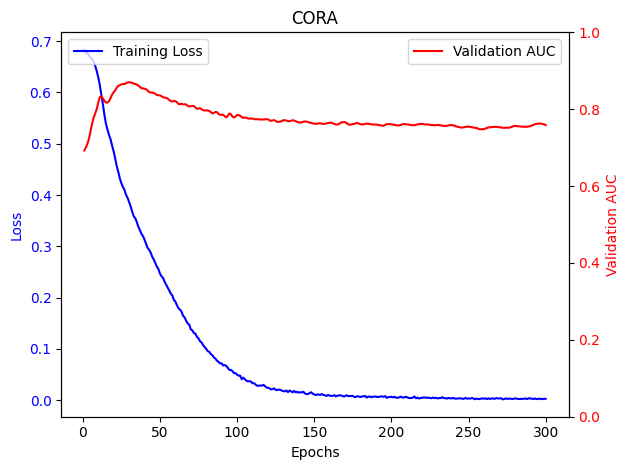

In [347]:
# 绘制损失曲线和验证集AUC
fig, ax1 = plt.subplots()

# 绘制训练损失曲线
ax1.plot(range(1, EPOCHS + 1), losses, label='Training Loss', color='blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 创建第二个坐标轴，用于绘制验证集AUC
ax2 = ax1.twinx()
ax2.plot(range(1, EPOCHS + 1), val_roc_values, label='Validation AUC', color='red')
ax2.set_ylabel('Validation AUC', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim([0, 1])

# 标题和图例
plt.title('CORA')
fig.tight_layout()

# 添加图例，显示训练损失和验证 AUC
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0))
ax2.legend(loc='upper left', bbox_to_anchor=(0.67, 1.0))
plt.savefig('CORA_loss.pdf')

# 显示和保存图像
plt.show()


In [336]:
# Print best results
print(f"Best Val ROC: {best_val_roc:.5f}, Best Test ROC: {best_test_roc:.6f}")
print(f"Best Val AP: {best_val_ap:.5f}, Best Test AP: {best_test_ap:.6f}")

Best Val ROC: 0.87015, Best Test ROC: 0.865354
Best Val AP: 0.87226, Best Test AP: 0.864887


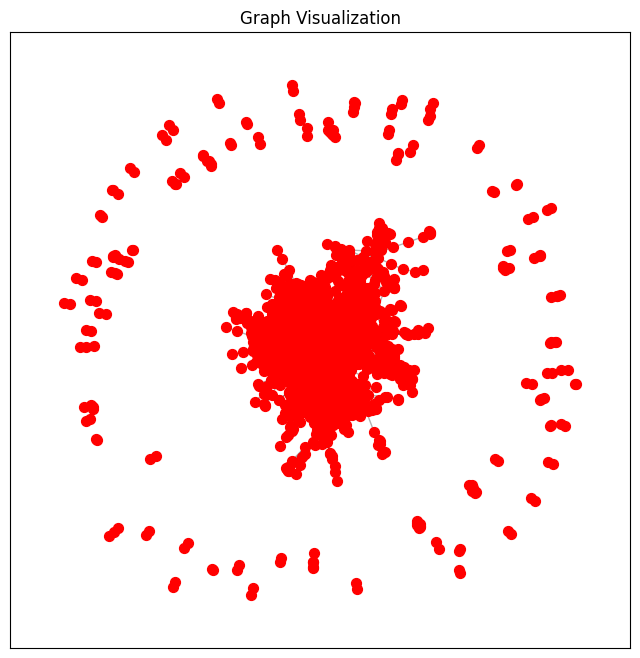

In [337]:
# Visualization (Optional)
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='red')
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Graph Visualization")
plt.show()